In [2]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from datetime import datetime, timedelta
import numba
import joblib 


/Users/neilkloot/anaconda/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
pd.options.display.max_rows=500
pd.options.display.max_columns=500
%load_ext autoreload
%autoreload 2


In [4]:
def load(filename):
    """Loads a compressed object from disk
    """
    model_object = joblib.load(filename)
    return model_object


In [5]:
all_df = pd.read_pickle('../data/ml-ta-all-data-201908262001.pkl.gz', compression='gzip')
print('Data loaded')
print(all_df.shape)

Data loaded
(1079523, 1227)


In [6]:
from optimise_dataframe import optimise_df

all_df = optimise_df(all_df)
train_df = all_df

In [7]:
del all_df

In [8]:
target_col = 'target'

numeric_cols = []
category_cols = []

for col in train_df.columns:
    if train_df[col].dtype.name == 'object':
        print(col, train_df[col].dtype.name)
    elif train_df[col].dtype.name == 'category' and col != target_col:
        category_cols.append(col)
        print('category:', col)
    elif train_df[col].dtype.name != 'int8' and col != target_col:
        numeric_cols.append(col)
    elif col == target_col:
        print('--- Target', col, train_df[col].dtype.name)

# print(numeric_cols)


category: one_week_bollinger_prediction
category: two_week_bollinger_prediction
category: four_week_bollinger_prediction
category: eight_week_bollinger_prediction
category: twelve_week_bollinger_prediction
category: twenty_six_week_bollinger_prediction
category: fifty_two_week_bollinger_prediction
category: one_week_bollinger_type
category: two_week_bollinger_type
category: four_week_bollinger_type
category: eight_week_bollinger_type
category: twelve_week_bollinger_type
category: twenty_six_week_bollinger_type
category: fifty_two_week_bollinger_type
category: symbol
category: GICSSector
category: GICSIndustryGroup
category: GICSIndustry
--- Target target float32


In [9]:
from sklearn import preprocessing

# Scale all numeric columns excluding target col

# scaler = load('../models/scaler.joblib.z') 

print('Scaling', len(numeric_cols), 'of', train_df.shape[1], 'cols')

scaler = preprocessing.RobustScaler()

# Fill any infinities, -infinites, NaNs which will cause scaler to fail
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df[numeric_cols] = train_df[numeric_cols].fillna(0)

# Transform data and fill any NAs
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
train_df[numeric_cols] = train_df[numeric_cols].fillna(0)


Scaling 1007 of 1227 cols


In [10]:
def one_hot_encode_field(df, column_name, categories):
    new_cols = pd.get_dummies(df[column_name])
    new_cols = new_cols.astype('int8', errors='ignore')

    new_cols.T.reindex(categories).T.fillna(0)
    
    name_map = {}
    # rename the categories
    for val in categories:
        name_map[val] = val

    new_cols.rename(name_map, axis=1, inplace=True)
    
    # Remove the original column
    df.drop([column_name], axis=1, inplace=True)
    
    # Return df with new cols 
    return pd.concat([df, new_cols], axis=1)



In [11]:
from sklearn.preprocessing import LabelEncoder

def prep_class_index(df, column_name, categories):
    # Create 
    val_map = {}
    for i in range(len(categories)):
        val_map[categories[i]] = i
        
    print(val_map)
    df['class_index'] = df[column_name].map(val_map).values
    
    # Return df with new target index col
    return df


In [12]:
bins = [-99.07692719, -13.13461361, -3.00000238, 0.,9.25964718, 1493.]
bin_names = ['strong_sell', 'sell', 'hold', 'buy', 'strong_buy']


In [63]:
train_df.columns.isin(['target'])

array([False, False, False, ..., False, False, False])

In [14]:
# prep data for training with one hot encoding
discretised_df = train_df
discretised_df['class'] = pd.cut(discretised_df['target'], bins=bins,labels=bin_names)
discretised_df = prep_class_index(discretised_df, 'class', bin_names)
discretised_df = one_hot_encode_field(discretised_df, 'class', bin_names)


{'strong_sell': 0, 'sell': 1, 'hold': 2, 'buy': 3, 'strong_buy': 4}


In [ ]:
train_df[numeric_cols].head(100)

In [15]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras import optimizers

# Determine unique vals for each category
col_vals_dict = {c: list(train_df[c].unique()) for c in category_cols}

embed_cols = []
for c in category_cols:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions

        
# Build embedding network for category cols
inputs = []
embeddings = []

for c in embed_cols:
    embedding_input = Input(shape=(1,))
    vocab_size = len(col_vals_dict[c]) + 1
    embedding_size = int(min(np.ceil(vocab_size/2), 50))
    embedding = Embedding(vocab_size, embedding_size, input_length=1)(embedding_input)
    embedding = Reshape(target_shape=(embedding_size,))(embedding)
    print('Create embedding', c, col_vals_dict[c])
    print('Embedding size', embedding_size)
    print('Vocab size', vocab_size)
    inputs.append(embedding_input)
    embeddings.append(embedding)
    
# Add embedding for numeric cols
input_numeric = Input(shape=(len(numeric_cols),))
embedding_numeric = Dense(len(numeric_cols))(input_numeric) 
inputs.append(input_numeric)
embeddings.append(embedding_numeric)
print('Create numeric embedding')
print('Input shape', (len(numeric_cols),))


# Build model
x = Concatenate()(embeddings)
x = Dense(1000, activation='relu')(x)
x = Dropout(.15)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(.15)(x)
x = Dense(200, activation='relu', name="int_layer")(x)
x = Dropout(.15)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs, output)
                             
model.summary()

model.compile(loss='kullback_leibler_divergence', optimizer=optimizers.Adamax(learning_rate=0.006),
              metrics=['accuracy'])

intermediate_model = Model(inputs=model.input, outputs=model.get_layer('int_layer').output)


one_week_bollinger_prediction: 3 values
two_week_bollinger_prediction: 3 values
four_week_bollinger_prediction: 3 values
eight_week_bollinger_prediction: 3 values
twelve_week_bollinger_prediction: 3 values
twenty_six_week_bollinger_prediction: 3 values
fifty_two_week_bollinger_prediction: 3 values
one_week_bollinger_type: 3 values
two_week_bollinger_type: 3 values
four_week_bollinger_type: 3 values
eight_week_bollinger_type: 3 values
twelve_week_bollinger_type: 3 values
twenty_six_week_bollinger_type: 3 values
fifty_two_week_bollinger_type: 3 values
symbol: 2632 values
GICSSector: 13 values
GICSIndustryGroup: 26 values
GICSIndustry: 69 values
Create embedding one_week_bollinger_prediction ['Steady', 'Falling', 'Rising']
Embedding size 2
Vocab size 4
Create embedding two_week_bollinger_prediction ['Steady', 'Falling', 'Rising']
Embedding size 2
Vocab size 4
Create embedding four_week_bollinger_prediction ['Steady', 'Falling', 'Rising']
Embedding size 2
Vocab size 4
Create embedding eigh

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

In [16]:
# Prep data for model

input_list_train = []

# the cols to be embedded: rescaling to range [0, # values)
for c in category_cols:
    print('Processing', c)
    raw_vals = np.unique(train_df[c])
    val_map = {}
    for i in range(len(raw_vals)):
        val_map[raw_vals[i]] = i       
    input_list_train.append(train_df[c].map(val_map).values)

#the rest of the columns
print('Processing numeric cols')
print(train_df[numeric_cols].shape)
input_list_train.append(train_df[numeric_cols].values)

print('Train X len', len(input_list_train))
print('Train X nulls', train_df[category_cols].isnull().any().sum())


Processing one_week_bollinger_prediction
Processing two_week_bollinger_prediction
Processing four_week_bollinger_prediction
Processing eight_week_bollinger_prediction
Processing twelve_week_bollinger_prediction
Processing twenty_six_week_bollinger_prediction
Processing fifty_two_week_bollinger_prediction
Processing one_week_bollinger_type
Processing two_week_bollinger_type
Processing four_week_bollinger_type
Processing eight_week_bollinger_type
Processing twelve_week_bollinger_type
Processing twenty_six_week_bollinger_type
Processing fifty_two_week_bollinger_type
Processing symbol
Processing GICSSector
Processing GICSIndustryGroup
Processing GICSIndustry
Processing numeric cols
(1079523, 1007)
Train X len 19
Train X nulls 0


In [17]:
# Set y values
y_train = discretised_df[bin_names].values
print('Train y shape', y_train.shape)

print('Train y nulls', discretised_df[bin_names].isnull().any().sum())


Train y shape (1079523, 5)
Train y nulls 0


In [18]:
# Train model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
model.fit(input_list_train, y_train, epochs=1000, batch_size=256, verbose=1, callbacks=[reduce_lr])

# 500, 200, 100 lr 0.004 => epoch 60: loss: 1.2622, accuracy: 0.4701, num lr reductions: 0
# 1000, 500, 200 lr 0.006 => epoch 60: loss: 1.3076, accuracy: 0.4484, num lr reductions: 0
# 1000, 500, 200 lr 0.006 => epoch 1000: loss: , accuracy: , num lr reductions: 


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1000
1079523/1079523 [==============================] - 960s 889us/step - loss: 1.8394 - accuracy: 0.2057
Epoch 2/1000
1079523/1079523 [==============================] - 291s 270us/step - loss: 1.6085 - accuracy: 0.2045
Epoch 3/1000
1079523/1079523 [==============================] - 305s 282us/step - loss: 1.6082 - accuracy: 0.2050
Epoch 4/1000
1079523/1079523 [==============================] - 324s 300us/step - loss: 1.6081 - accuracy: 0.2041
Epoch 5/1000
1079523/1079523 [==============================] - 324s 301us/step - loss: 1.6079 - accuracy: 0.2046
Epoch 6/1000
1079523/1079523 [==============================] - 325s 301us/step - loss: 1.6077 - accuracy: 0.2050
Epoch 7/1000
1079523/1079523 [==============================] - 325s 301us/step - loss: 1.6077 - accuracy: 0.2050
Epoch 8/1000
1079523/1079523 [==============================] - 326s 302us/step - loss: 1.6077 - accuracy: 0.2051
Epoch 9/1000
1079523/1079523 [==============================] - 326s 302us/step - loss: 

1079523/1079523 [==============================] - 324s 300us/step - loss: 1.2903 - accuracy: 0.4564
Epoch 71/1000
1079523/1079523 [==============================] - 323s 299us/step - loss: 1.2889 - accuracy: 0.4574
Epoch 72/1000
1079523/1079523 [==============================] - 324s 300us/step - loss: 1.2877 - accuracy: 0.4582
Epoch 73/1000
1079523/1079523 [==============================] - 325s 301us/step - loss: 1.2868 - accuracy: 0.4585
Epoch 74/1000
1079523/1079523 [==============================] - 323s 300us/step - loss: 1.2840 - accuracy: 0.4597
Epoch 75/1000
1079523/1079523 [==============================] - 323s 300us/step - loss: 1.2825 - accuracy: 0.4603
Epoch 76/1000
1079523/1079523 [==============================] - 324s 300us/step - loss: 1.2818 - accuracy: 0.4601
Epoch 77/1000
1079523/1079523 [==============================] - 323s 299us/step - loss: 1.2810 - accuracy: 0.4610
Epoch 78/1000
1079523/1079523 [==============================] - 323s 299us/step - loss: 1.279

1079523/1079523 [==============================] - 329s 305us/step - loss: 1.2122 - accuracy: 0.4931
Epoch 142/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.2122 - accuracy: 0.4940
Epoch 143/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.2114 - accuracy: 0.4938
Epoch 144/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.2114 - accuracy: 0.4945
Epoch 145/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.2095 - accuracy: 0.4954
Epoch 146/1000
1079523/1079523 [==============================] - 329s 304us/step - loss: 1.2093 - accuracy: 0.4952
Epoch 147/1000
1079523/1079523 [==============================] - 330s 305us/step - loss: 1.2083 - accuracy: 0.4954
Epoch 148/1000
1079523/1079523 [==============================] - 331s 307us/step - loss: 1.2068 - accuracy: 0.4959
Epoch 149/1000
1079523/1079523 [==============================] - 331s 306us/step - los

1079523/1079523 [==============================] - 360s 333us/step - loss: 1.1600 - accuracy: 0.5178
Epoch 212/1000
1079523/1079523 [==============================] - 362s 335us/step - loss: 1.1593 - accuracy: 0.5187
Epoch 213/1000
1079523/1079523 [==============================] - 360s 333us/step - loss: 1.1579 - accuracy: 0.5190
Epoch 214/1000
1079523/1079523 [==============================] - 361s 334us/step - loss: 1.1575 - accuracy: 0.5190
Epoch 215/1000
1079523/1079523 [==============================] - 360s 333us/step - loss: 1.1578 - accuracy: 0.5198
Epoch 216/1000
1079523/1079523 [==============================] - 361s 335us/step - loss: 1.1560 - accuracy: 0.5200
Epoch 217/1000
1079523/1079523 [==============================] - 362s 336us/step - loss: 1.1559 - accuracy: 0.5202
Epoch 218/1000
1079523/1079523 [==============================] - 363s 336us/step - loss: 1.1555 - accuracy: 0.5202
Epoch 219/1000
1079523/1079523 [==============================] - 360s 333us/step - los

1079523/1079523 [==============================] - 335s 311us/step - loss: 1.1176 - accuracy: 0.5381
Epoch 282/1000
1079523/1079523 [==============================] - 335s 310us/step - loss: 1.1161 - accuracy: 0.5387
Epoch 283/1000
1079523/1079523 [==============================] - 335s 310us/step - loss: 1.1162 - accuracy: 0.5389
Epoch 284/1000
1079523/1079523 [==============================] - 335s 311us/step - loss: 1.1140 - accuracy: 0.5394
Epoch 285/1000
1079523/1079523 [==============================] - 335s 310us/step - loss: 1.1148 - accuracy: 0.5391
Epoch 286/1000
1079523/1079523 [==============================] - 337s 312us/step - loss: 1.1137 - accuracy: 0.5397
Epoch 287/1000
1079523/1079523 [==============================] - 336s 311us/step - loss: 1.1136 - accuracy: 0.5395
Epoch 288/1000
1079523/1079523 [==============================] - 334s 309us/step - loss: 1.1130 - accuracy: 0.5397
Epoch 289/1000
1079523/1079523 [==============================] - 335s 311us/step - los

1079523/1079523 [==============================] - 312s 289us/step - loss: 1.0666 - accuracy: 0.5608
Epoch 351/1000
1079523/1079523 [==============================] - 320s 297us/step - loss: 1.0666 - accuracy: 0.5602
Epoch 352/1000
1079523/1079523 [==============================] - 291s 269us/step - loss: 1.0658 - accuracy: 0.5609 - loss: 1
Epoch 353/1000
1079523/1079523 [==============================] - 303s 280us/step - loss: 1.0664 - accuracy: 0.5607
Epoch 354/1000
1079523/1079523 [==============================] - 296s 275us/step - loss: 1.0670 - accuracy: 0.5603
Epoch 355/1000
1079523/1079523 [==============================] - 299s 277us/step - loss: 1.0657 - accuracy: 0.5609
Epoch 356/1000
1079523/1079523 [==============================] - 301s 279us/step - loss: 1.0661 - accuracy: 0.5611
Epoch 357/1000
1079523/1079523 [==============================] - 303s 281us/step - loss: 1.0646 - accuracy: 0.5612
Epoch 358/1000
1079523/1079523 [==============================] - 304s 282us/

Epoch 420/1000
1079523/1079523 [==============================] - 333s 308us/step - loss: 1.0552 - accuracy: 0.5658
Epoch 421/1000
1079523/1079523 [==============================] - 334s 309us/step - loss: 1.0559 - accuracy: 0.5652
Epoch 422/1000
1079523/1079523 [==============================] - 333s 309us/step - loss: 1.0560 - accuracy: 0.5654
Epoch 423/1000
1079523/1079523 [==============================] - 334s 310us/step - loss: 1.0562 - accuracy: 0.5651
Epoch 424/1000
1079523/1079523 [==============================] - 333s 308us/step - loss: 1.0556 - accuracy: 0.5653
Epoch 425/1000
1079523/1079523 [==============================] - 333s 308us/step - loss: 1.0556 - accuracy: 0.5659
Epoch 426/1000
1079523/1079523 [==============================] - 332s 308us/step - loss: 1.0563 - accuracy: 0.5655
Epoch 427/1000
1079523/1079523 [==============================] - 331s 307us/step - loss: 1.0557 - accuracy: 0.5654
Epoch 428/1000
1079523/1079523 [==============================] - 331s 3

1079523/1079523 [==============================] - 335s 310us/step - loss: 1.0532 - accuracy: 0.5667
Epoch 491/1000
1079523/1079523 [==============================] - 334s 309us/step - loss: 1.0538 - accuracy: 0.5664
Epoch 492/1000
1079523/1079523 [==============================] - 328s 304us/step - loss: 1.0525 - accuracy: 0.5666
Epoch 493/1000
1079523/1079523 [==============================] - 302s 279us/step - loss: 1.0532 - accuracy: 0.5667
Epoch 494/1000
1079523/1079523 [==============================] - 304s 282us/step - loss: 1.0528 - accuracy: 0.5664
Epoch 495/1000
1079523/1079523 [==============================] - 301s 278us/step - loss: 1.0540 - accuracy: 0.5660
Epoch 496/1000
1079523/1079523 [==============================] - 314s 291us/step - loss: 1.0531 - accuracy: 0.5670
Epoch 497/1000
1079523/1079523 [==============================] - 320s 297us/step - loss: 1.0530 - accuracy: 0.5666 - loss: 1.0530 - accu
Epoch 498/1000
1079523/1079523 [==============================] -

1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0502 - accuracy: 0.5681
Epoch 561/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0507 - accuracy: 0.5680
Epoch 562/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0503 - accuracy: 0.5678
Epoch 563/1000
1079523/1079523 [==============================] - 330s 305us/step - loss: 1.0498 - accuracy: 0.5684
Epoch 564/1000
1079523/1079523 [==============================] - 328s 304us/step - loss: 1.0512 - accuracy: 0.5675
Epoch 565/1000
1079523/1079523 [==============================] - 329s 304us/step - loss: 1.0501 - accuracy: 0.5688
Epoch 566/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0501 - accuracy: 0.5685
Epoch 567/1000
1079523/1079523 [==============================] - 330s 305us/step - loss: 1.0499 - accuracy: 0.5679
Epoch 568/1000
1079523/1079523 [==============================] - 329s 305us/step - los

1079523/1079523 [==============================] - 338s 313us/step - loss: 1.0479 - accuracy: 0.5691
Epoch 631/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0482 - accuracy: 0.5690
Epoch 632/1000
1079523/1079523 [==============================] - 331s 306us/step - loss: 1.0477 - accuracy: 0.5692
Epoch 633/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0477 - accuracy: 0.5688
Epoch 634/1000
1079523/1079523 [==============================] - 344s 319us/step - loss: 1.0478 - accuracy: 0.5693
Epoch 635/1000
1079523/1079523 [==============================] - 332s 307us/step - loss: 1.0479 - accuracy: 0.5693
Epoch 636/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0478 - accuracy: 0.5693
Epoch 637/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0484 - accuracy: 0.5687
Epoch 638/1000
1079523/1079523 [==============================] - 327s 303us/step - los

1079523/1079523 [==============================] - 331s 307us/step - loss: 1.0468 - accuracy: 0.5693
Epoch 701/1000
1079523/1079523 [==============================] - 332s 308us/step - loss: 1.0453 - accuracy: 0.5698
Epoch 702/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0458 - accuracy: 0.5702
Epoch 703/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0464 - accuracy: 0.5704
Epoch 704/1000
1079523/1079523 [==============================] - 333s 309us/step - loss: 1.0455 - accuracy: 0.5706
Epoch 705/1000
1079523/1079523 [==============================] - 331s 307us/step - loss: 1.0456 - accuracy: 0.5705
Epoch 706/1000
1079523/1079523 [==============================] - 332s 308us/step - loss: 1.0466 - accuracy: 0.5701
Epoch 707/1000
1079523/1079523 [==============================] - 332s 308us/step - loss: 1.0454 - accuracy: 0.5702
Epoch 708/1000
1079523/1079523 [==============================] - 331s 307us/step - los

1079523/1079523 [==============================] - 278s 258us/step - loss: 1.0432 - accuracy: 0.5711
Epoch 771/1000
1079523/1079523 [==============================] - 279s 258us/step - loss: 1.0446 - accuracy: 0.5707
Epoch 772/1000
1079523/1079523 [==============================] - 281s 260us/step - loss: 1.0438 - accuracy: 0.5709 - loss: 1
Epoch 773/1000
1079523/1079523 [==============================] - 323s 300us/step - loss: 1.0436 - accuracy: 0.5710
Epoch 774/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0434 - accuracy: 0.5712
Epoch 775/1000
1079523/1079523 [==============================] - 333s 308us/step - loss: 1.0435 - accuracy: 0.5713
Epoch 776/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0436 - accuracy: 0.5713
Epoch 777/1000
1079523/1079523 [==============================] - 331s 307us/step - loss: 1.0444 - accuracy: 0.5710
Epoch 778/1000
1079523/1079523 [==============================] - 330s 306us/

1079523/1079523 [==============================] - 331s 306us/step - loss: 1.0413 - accuracy: 0.5717
Epoch 841/1000
1079523/1079523 [==============================] - 327s 303us/step - loss: 1.0412 - accuracy: 0.5723
Epoch 842/1000
1079523/1079523 [==============================] - 331s 307us/step - loss: 1.0414 - accuracy: 0.5719
Epoch 843/1000
1079523/1079523 [==============================] - 326s 302us/step - loss: 1.0414 - accuracy: 0.5724
Epoch 844/1000
1079523/1079523 [==============================] - 329s 304us/step - loss: 1.0420 - accuracy: 0.5724
Epoch 845/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0415 - accuracy: 0.5721
Epoch 846/1000
1079523/1079523 [==============================] - 328s 304us/step - loss: 1.0414 - accuracy: 0.5723
Epoch 847/1000
1079523/1079523 [==============================] - 327s 303us/step - loss: 1.0430 - accuracy: 0.5713
Epoch 848/1000
1079523/1079523 [==============================] - 326s 302us/step - los

1079523/1079523 [==============================] - 339s 314us/step - loss: 1.0403 - accuracy: 0.5726
Epoch 911/1000
1079523/1079523 [==============================] - 285s 264us/step - loss: 1.0402 - accuracy: 0.5732
Epoch 912/1000
1079523/1079523 [==============================] - 279s 258us/step - loss: 1.0403 - accuracy: 0.5728
Epoch 913/1000
1079523/1079523 [==============================] - 282s 261us/step - loss: 1.0390 - accuracy: 0.5725
Epoch 914/1000
1079523/1079523 [==============================] - 277s 257us/step - loss: 1.0391 - accuracy: 0.5730
Epoch 915/1000
1079523/1079523 [==============================] - 320s 296us/step - loss: 1.0393 - accuracy: 0.5731
Epoch 916/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0391 - accuracy: 0.5734
Epoch 917/1000
1079523/1079523 [==============================] - 332s 308us/step - loss: 1.0400 - accuracy: 0.5728
Epoch 918/1000
1079523/1079523 [==============================] - 334s 310us/step - los

1079523/1079523 [==============================] - 329s 304us/step - loss: 1.0385 - accuracy: 0.5736
Epoch 981/1000
1079523/1079523 [==============================] - 331s 307us/step - loss: 1.0383 - accuracy: 0.5735
Epoch 982/1000
1079523/1079523 [==============================] - 330s 305us/step - loss: 1.0381 - accuracy: 0.5741
Epoch 983/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0373 - accuracy: 0.5739
Epoch 984/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0366 - accuracy: 0.5744
Epoch 985/1000
1079523/1079523 [==============================] - 329s 305us/step - loss: 1.0371 - accuracy: 0.5742
Epoch 986/1000
1079523/1079523 [==============================] - 330s 306us/step - loss: 1.0376 - accuracy: 0.5742
Epoch 987/1000
1079523/1079523 [==============================] - 327s 303us/step - loss: 1.0374 - accuracy: 0.5742
Epoch 988/1000
1079523/1079523 [==============================] - 326s 302us/step - los

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
pred_y = model.predict(input_list_train)

intermediate_vals = intermediate_model.predict(input_list_train)

In [21]:
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

class_labels = np.argmax(pred_y, axis=1)
class_vector_one_hot = to_categorical(class_labels)
class_actuals = np.argmax(y_train, axis=1)

print(accuracy_score(y_train, class_vector_one_hot))

print(accuracy_score(class_actuals, class_labels))



0.6354102691651776
0.6359892285759544


In [ ]:
class_actuals[0:100]

In [ ]:
pred_class_labels[0:100]

In [ ]:
bin_names

Scoring
Accuracy: 0.6359892285759544
Confusion matrix, without normalization
[[172654  25099    950   2299   8681]
 [ 47572 126546   5972  23612  16552]
 [ 18269  37208 105547  39887  13690]
 [ 14445  31565  10396 129894  35322]
 [ 20337  11058   1356  28688 151924]]
Normalized confusion matrix
[[0.82 0.12 0.   0.01 0.04]
 [0.22 0.57 0.03 0.11 0.08]
 [0.09 0.17 0.49 0.19 0.06]
 [0.07 0.14 0.05 0.59 0.16]
 [0.1  0.05 0.01 0.13 0.71]]


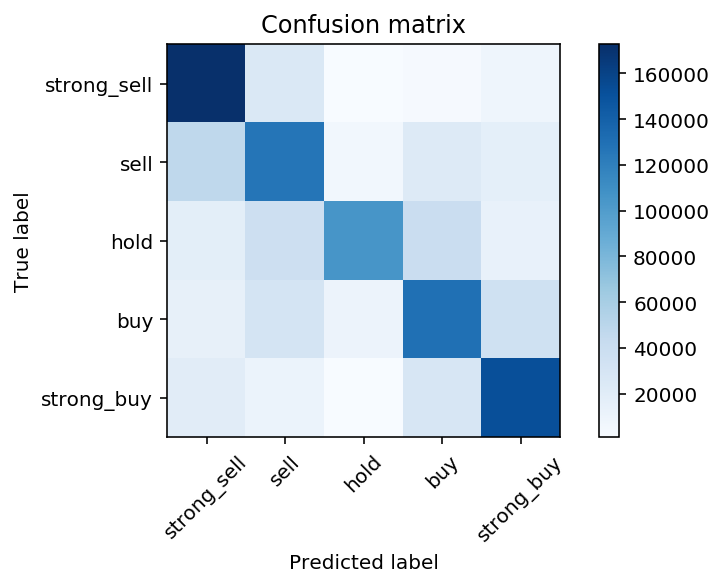

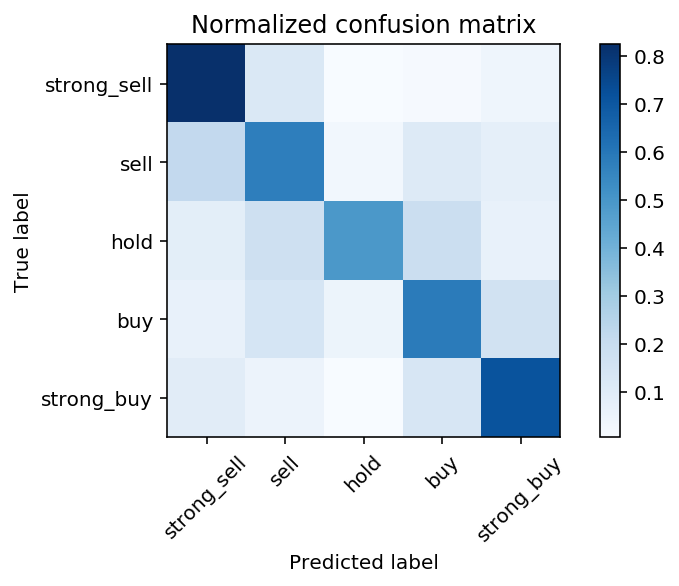

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


print('Scoring')
pred_y = model.predict(input_list_train)
pred_class_labels = np.argmax(pred_y, axis=1)
class_actuals = np.argmax(y_train, axis=1)
score = accuracy_score(class_actuals, pred_class_labels)
 
print('Accuracy:', score)

cm = confusion_matrix(class_actuals, pred_class_labels)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, bin_names, title='Confusion matrix')

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix')

In [24]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

histogram_model = HistGradientBoostingClassifier(
    max_iter=343, 
    max_leaf_nodes=623, 
    learning_rate=0.1, 
    min_samples_leaf=2, 
    l2_regularization=0.,
    verbose=1
)
    
print('-' * 50)
print('Fitting histogram model')
histogram_model.fit(intermediate_vals, class_actuals)
print('-' * 50)
print('Histogram model done')

train_pred_y = histogram_model.predict(intermediate_vals)



--------------------------------------------------
Fitting histogram model
Binning 1.727 GB of data: 11.247 s
Fitting gradient boosted rounds:
[1/343] 5 trees, 3115 leaves (623 on avg), max depth = 26, in 14.447s
[2/343] 5 trees, 3115 leaves (623 on avg), max depth = 32, in 16.124s
[3/343] 5 trees, 3115 leaves (623 on avg), max depth = 30, in 18.390s
[4/343] 5 trees, 3115 leaves (623 on avg), max depth = 31, in 19.679s
[5/343] 5 trees, 3115 leaves (623 on avg), max depth = 33, in 20.530s
[6/343] 5 trees, 3115 leaves (623 on avg), max depth = 40, in 14.894s
[7/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 15.179s
[8/343] 5 trees, 3115 leaves (623 on avg), max depth = 46, in 13.542s
[9/343] 5 trees, 3115 leaves (623 on avg), max depth = 44, in 9.678s
[10/343] 5 trees, 3115 leaves (623 on avg), max depth = 46, in 13.004s
[11/343] 5 trees, 3115 leaves (623 on avg), max depth = 51, in 14.532s
[12/343] 5 trees, 3115 leaves (623 on avg), max depth = 50, in 9.611s
[13/343] 5 trees

[115/343] 5 trees, 3115 leaves (623 on avg), max depth = 50, in 9.720s
[116/343] 5 trees, 3115 leaves (623 on avg), max depth = 47, in 7.545s
[117/343] 5 trees, 3115 leaves (623 on avg), max depth = 37, in 6.851s
[118/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 10.018s
[119/343] 5 trees, 3115 leaves (623 on avg), max depth = 40, in 8.520s
[120/343] 5 trees, 3115 leaves (623 on avg), max depth = 56, in 6.503s
[121/343] 5 trees, 3115 leaves (623 on avg), max depth = 44, in 10.202s
[122/343] 5 trees, 3115 leaves (623 on avg), max depth = 58, in 9.213s
[123/343] 5 trees, 3115 leaves (623 on avg), max depth = 53, in 5.905s
[124/343] 5 trees, 3115 leaves (623 on avg), max depth = 54, in 9.667s
[125/343] 5 trees, 3115 leaves (623 on avg), max depth = 41, in 10.628s
[126/343] 5 trees, 3115 leaves (623 on avg), max depth = 46, in 6.007s
[127/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 8.424s
[128/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 10.103s
[1

[230/343] 5 trees, 3115 leaves (623 on avg), max depth = 42, in 6.272s
[231/343] 5 trees, 3115 leaves (623 on avg), max depth = 50, in 10.013s
[232/343] 5 trees, 3115 leaves (623 on avg), max depth = 41, in 11.043s
[233/343] 5 trees, 3115 leaves (623 on avg), max depth = 38, in 5.685s
[234/343] 5 trees, 3115 leaves (623 on avg), max depth = 48, in 9.206s
[235/343] 5 trees, 3115 leaves (623 on avg), max depth = 41, in 11.398s
[236/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 5.978s
[237/343] 5 trees, 3115 leaves (623 on avg), max depth = 42, in 8.512s
[238/343] 5 trees, 3115 leaves (623 on avg), max depth = 41, in 11.629s
[239/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 9.800s
[240/343] 5 trees, 3115 leaves (623 on avg), max depth = 42, in 7.735s
[241/343] 5 trees, 3115 leaves (623 on avg), max depth = 44, in 10.906s
[242/343] 5 trees, 3115 leaves (623 on avg), max depth = 42, in 11.868s
[243/343] 5 trees, 3115 leaves (623 on avg), max depth = 43, in 7.425s


NameError: name 'evaluate_classifier' is not defined

Scoring
Accuracy: 0.9330963768256906
Confusion matrix, without normalization
[[207498    886    213    633    453]
 [ 10947 201554    338   5974   1441]
 [  4814   7058 190454  10942   1333]
 [  4030   5367    805 206268   5152]
 [  6479   1161    222   3976 201525]]
Normalized confusion matrix
[[0.99 0.   0.   0.   0.  ]
 [0.05 0.92 0.   0.03 0.01]
 [0.02 0.03 0.89 0.05 0.01]
 [0.02 0.02 0.   0.93 0.02]
 [0.03 0.01 0.   0.02 0.94]]


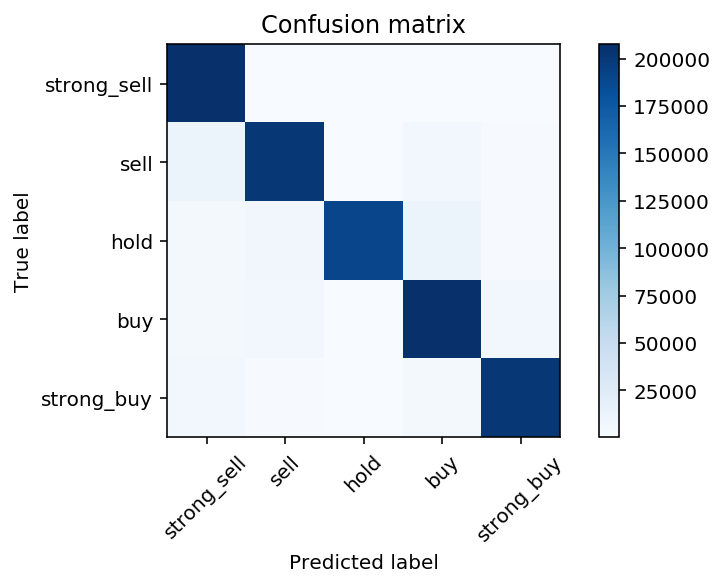

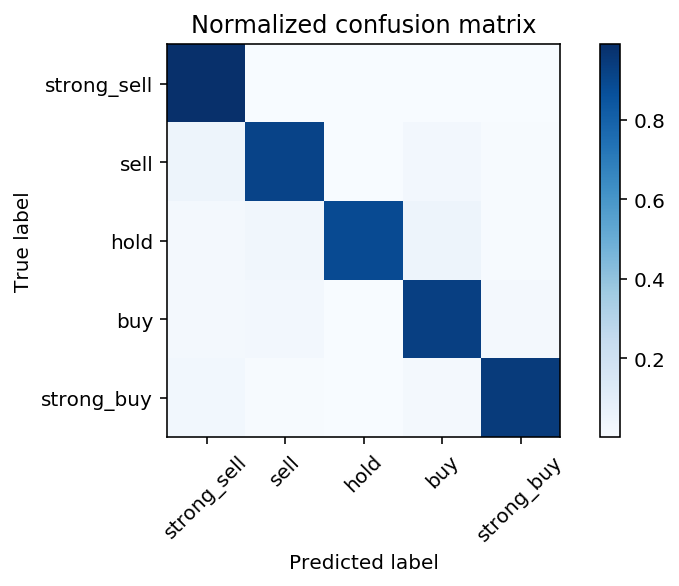

In [26]:
print('Scoring')
pred_class_labels = train_pred_y
score = accuracy_score(class_actuals, pred_class_labels)
 
print('Accuracy:', score)

cm = confusion_matrix(class_actuals, pred_class_labels)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, bin_names, title='Confusion matrix')

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix')